# Exploring the generated data

In [200]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pprint import pprint

## Dataset locations

There are two dataset files, `foreground*.hdf` and `injections*.hdf`.  
- `foreground` contains the waveforms, as well as some important metadata;
- `injections` contains information about the time of the injection as well as their physical parameters.

In [190]:
FOREGROUND_FILE = 'foreground_tiny.hdf'
INJECTION_FILE = 'injections_tiny.hdf'

## Foreground file

### Root level

First, we will explore the `foreground` file to see how it is organized and what information it contains.

In [203]:
with h5py.File(FOREGROUND_FILE, 'r') as f:
    # Print the keys at the root level of the file
    group_names = list(f.keys())
    print(f"{group_names=}")
    
    # Print the attributes at the root level of the file
    file_attrs = list(f.attrs)
    pprint(f"{file_attrs=}")

group_names=['H1', 'L1']
("file_attrs=['background-file', 'dataset', 'detectors', 'duration', "
 "'f_lower', 'filter_duration', 'injection-file', 'low_frequency_cutoff', "
 "'min_segment_duration', 'padding_end', 'padding_start', 'real_noise_path', "
 "'sample_rate', 'seed', 'segment_path', 'slide_buffer', 'start_offset']")


So, the data in the file is organized by detector ('H1' is Hanford and 'L1' is LIGO).  
It appears that there are many attributes. Let's list their values.

In [ ]:
with h5py.File(FOREGROUND_FILE, 'r') as f:
    for key, value in f.attrs.items():
        print(f"{key}: {value}")
    

background-file: /lhome/ext/uv098/uv0986/MLGWSC1/ml-mock-data-challenge-1/TMP-1695901227.8024004-BG.hdf
dataset: 1
detectors: ['H1' 'L1']
duration: 86400
f_lower: 20
filter_duration: 128
injection-file: dsets/injections_tiny.hdf
low_frequency_cutoff: 15
min_segment_duration: 7200
padding_end: 30
padding_start: 30
real_noise_path: None
sample_rate: 2048
seed: 0
segment_path: None
slide_buffer: 240
start_offset: 0


We have many attributes, the most notable being:
- `dataset`, from 1 to 4, as explained in the MLGWSC
- `duration`, which is the duration, in seconds, of the generated data
- `sample_rate`, in Hz
- `seed` used during generation
- `injection_file`, contains the path to the associated injection file

### Datasets

Now we proceed to explore what is inside the data for one detector.

In [217]:
with h5py.File(FOREGROUND_FILE, 'r') as f:    
    # keys within the H1 group -> datasets
    dataset_names = list(f['H1'].keys())
    
    # How many datasets are in the H1 group?
    n_datasets = len(dataset_names)
    print(f"{n_datasets=}")
    
    # Print the name of the datasets in the H1 group
    print(f"{dataset_names=}")
    
    # Check if there are detector-soecific attributes
    print('H1 attributes: ', list(f['H1'].attrs))
    
    # Check if L1 has the same number of datasets
    assert len(list(f['L1'].keys())) == n_datasets

n_datasets=6
dataset_names=['1238205077', '1238400368', '1238546548', '1238561176', '1238612625', '1238645908']
H1 attributes:  []


For each detector, we have 6 datasets.  
There are no attributes for each detector.  
Let's delve into the datasets and find out their durations and data types

In [224]:
with h5py.File(FOREGROUND_FILE, 'r') as f:
    group = f['H1']
    dataset_names = list(group.keys())
    dataset_name = dataset_names[0]
    print(f"{dataset_name=}")
    dataset = group[dataset_name]
            
    # Print the shape and data type of the dataset
    print(f"{dataset.shape=}\n{dataset.dtype=}")
    
    # Find attributes of the dataset
    dataset_attrs = list(dataset.attrs)
    print(f"{dataset_attrs=}")
    
    # Print the value of the attributes in the dset
    print("\nDataset attributes:")
    for key, value in dataset.attrs.items():
        print(f"{key}: {value}")

dataset_name='1238205077'
dataset.shape=(20604928,)
dataset.dtype=dtype('<f8')
dataset_attrs=['delta_t', 'start_time']

Dataset attributes:
delta_t: 0.00048828125
start_time: 1238205077.0


In [ ]:
(20604928 * 0.00048828125) / 60 // 60, (20604928 * 0.00048828125) / 60 % 60

(2.0, 47.68333333333334)

So, the dataset name corresponds to its start time.  
The dataset has a length of about 20M points, taken at a interval of ~0.5ms, which gives about 2h45min of data.  
The data type is `float64` (8bytes * 8bits).  
Let's see if the length of the data is constant among datasets.

In [241]:
with h5py.File(FOREGROUND_FILE, 'r') as f:
    group = f['H1']
    dataset_names = list(group.keys())
    total_length = 0
    for dataset_name in dataset_names:
        dataset = group[dataset_name]
        print(f"{dataset_name=}", f"{dataset.shape=}")
        total_length += dataset.shape[0]
        
    # Check if we have exactly 1 day of data, as supposed.
    assert total_length * dataset.attrs['delta_t'] / 60 / 60 / 24 == 1

dataset_name='1238205077' dataset.shape=(20604928,)
dataset_name='1238400368' dataset.shape=(22710272,)
dataset_name='1238546548' dataset.shape=(18247680,)
dataset_name='1238561176' dataset.shape=(62007296,)
dataset_name='1238612625' dataset.shape=(15044608,)
dataset_name='1238645908' dataset.shape=(38332416,)


Each dataset has a different size but, in total, they contain 24h of data.

### Plotting the data

Finally, let's plot a small segment of data just to make sure everything is alright.

In [250]:
with h5py.File(FOREGROUND_FILE, 'r') as f:
    group = f['H1']
    dataset_names = list(group.keys())
    dataset_name = dataset_names[0]
    dataset = group[dataset_name]
    
    # Make a copy to allow closing the file.
    data = dataset[:]
    
    time_step = dataset.attrs['delta_t']
    start_time = dataset.attrs['start_time']

In [251]:
# Convert a range of ints from 0 to N to a range of timestamps starting at start_time and with a given time_step
def range_to_timestamps(start_time, time_step, N):
    return [start_time + i*time_step for i in range(N)]

In [252]:
times = range_to_timestamps(0, time_step, len(data))

Text(0, 0.5, 'Amplitude')

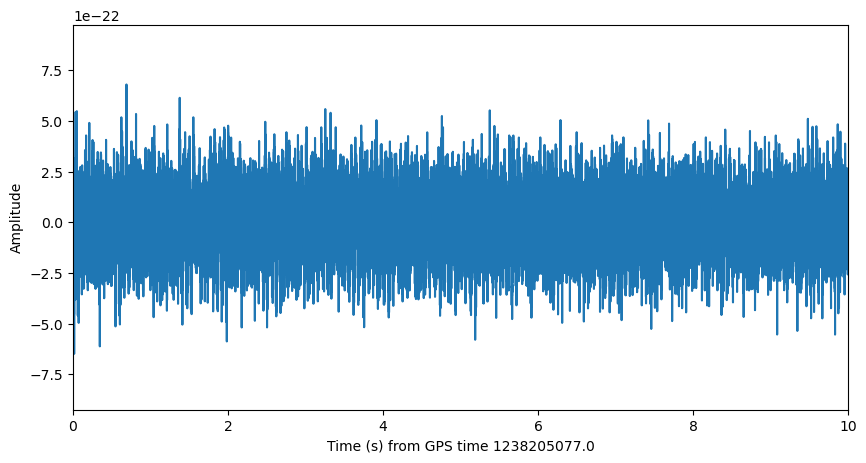

In [253]:
# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(times, data)
plt.xlim(0, 10)
plt.xlabel(f'Time (s) from GPS time {start_time}')
plt.ylabel('Amplitude')


It appears we indeed have "normal" data from LIGO.

## Injections file

Having explored the `foreground` file, we move to `injections.hdf`.

### Root level

Let's start with the information at the root level.

In [257]:
with h5py.File(INJECTION_FILE, 'r') as f:
    # Print the keys at the root level of the file
    group_names = list(f.keys())
    print(f"{group_names=}")
    
    # Print the name of the attributes at the root level of the file
    file_attrs = list(f.attrs)
    pprint(file_attrs)

group_names=['chirp_distance', 'coa_phase', 'dec', 'distance', 'inclination', 'mass1', 'mass2', 'mchirp', 'polarization', 'q', 'ra', 'tc']
['approximant',
 'cmd',
 'f_lower',
 'f_ref',
 'injtype',
 'mode_array',
 'spin1x',
 'spin1y',
 'spin1z',
 'spin2x',
 'spin2y',
 'spin2z',
 'static_args',
 'taper']


There are plenty of groups, as well as attributes.  
Let's print the value of the attributes.

In [258]:
with h5py.File(INJECTION_FILE, 'r') as f:
    group_names = list(f.keys())
    
    for key, value in f.attrs.items():
        print(f"{key}: {value}")

approximant: IMRPhenomXPHM
cmd: /lhome/ext/uv098/uv0986/mambaforge/envs/fastai/bin/pycbc_create_injections --config-files /lhome/ext/uv098/uv0986/MLGWSC1/ml-mock-data-challenge-1/ds1.ini --gps-start-time 1238205077 --gps-end-time 1253966055 --time-step 24 --time-window 6 --seed 0 --output-file dsets/injections_tiny.hdf
f_lower: 20.0
f_ref: 20.0
injtype: cbc
mode_array: 22.0
spin1x: 0.0
spin1y: 0.0
spin1z: 0.0
spin2x: 0.0
spin2y: 0.0
spin2z: 0.0
static_args: ['f_ref' 'f_lower' 'approximant' 'taper' 'spin1x' 'spin1y' 'spin1z'
 'spin2x' 'spin2y' 'spin2z' 'mode_array']
taper: start


### Physical parameters

It appears that the attributes show physical parameters which are fixed for this dataset, 
as well as the name of the approximant and the command used to geenerate it.

If we look again at the dataset names, they seem to be associated with physical parameters for each injection.  
The most important should be:
- `tc`: time of the coalescence
- `mass1`: mass of the first object, in solar masses
- `mass2`: mass of the second object, in solar masses
- `distance`: distance of the event, in Mpc

Let's grab them and see their distributions for this dataset.

In [259]:
with h5py.File(INJECTION_FILE, 'r') as f:        
    tcs = f["tc"][:]    
    masses1 = f["mass1"][:]
    masses2 = f["mass2"][:]
    distances = f["distance"][:]
    

First, we would expect the size of the previous datasets to be the same, as each entry should be associated with one injection.  
Let us verify that.

In [261]:
print(f"{tcs.shape=}")

assert tcs.shape == masses1.shape == masses2.shape == distances.shape

tcs.shape=(583771,)


Everything OK!  
What about the data types?

In [262]:
print(f"{tcs.dtype=}")
print(f"{masses1.dtype=}")
print(f"{masses2.dtype=}")
print(f"{distances.dtype=}")

tcs.dtype=dtype('float64')
masses1.dtype=dtype('float64')
masses2.dtype=dtype('float64')
distances.dtype=dtype('float64')


What is the time separation between adjacent events?

In [263]:
diffs = tcs[1:] - tcs[:-1]
np.mean(diffs), np.min(diffs), np.max(diffs)

(26.998559466548528, 24.00001311302185, 29.9999942779541)

Okay, they are separated by around 27 seconds, and at least 24 seconds.  
This makes sense because in the `generate_data` script we define ```TIME_STEP = 24``` .

Finally, the distributions of the physical parameters.

In [265]:
df = pd.DataFrame({"mass1": masses1, "mass2": masses2, "distance": distances})
df.head()

,mass1,mass2,distance
0,31.549643,26.052453,2935.667948
1,43.615601,38.633803,3754.137637
2,41.890456,40.748810,4792.421232
3,41.595813,37.922989,3447.392203
4,48.946327,38.270758,5441.803028


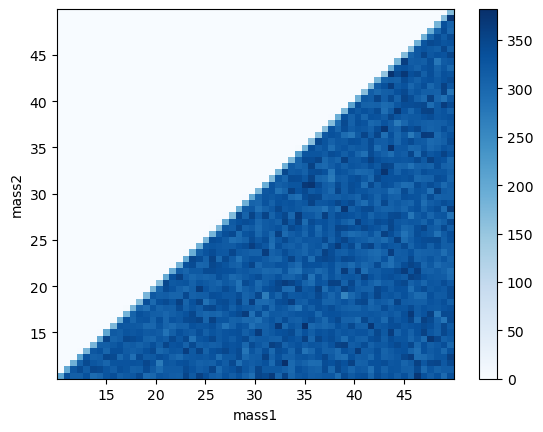

In [266]:
h = plt.hist2d(masses1, masses2, bins=60, cmap='Blues')
plt.xlabel('mass1')
plt.ylabel('mass2')
plt.colorbar(h[3]);

Text(0.5, 0, 'Distance (Mpc)')

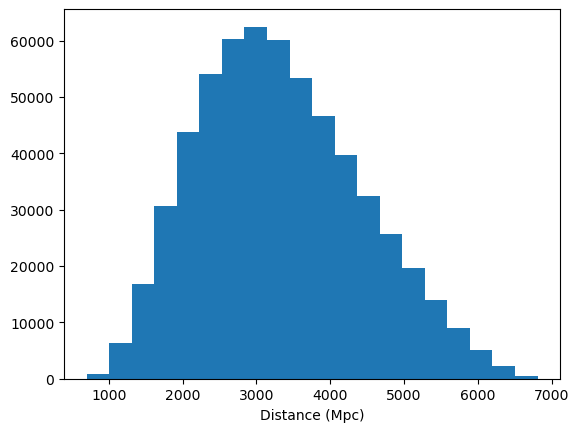

In [267]:
plt.hist(distances, bins=20)
plt.xlabel('Distance (Mpc)')

/lhome/ext/uv098/uv0986/mambaforge/envs/fastai/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


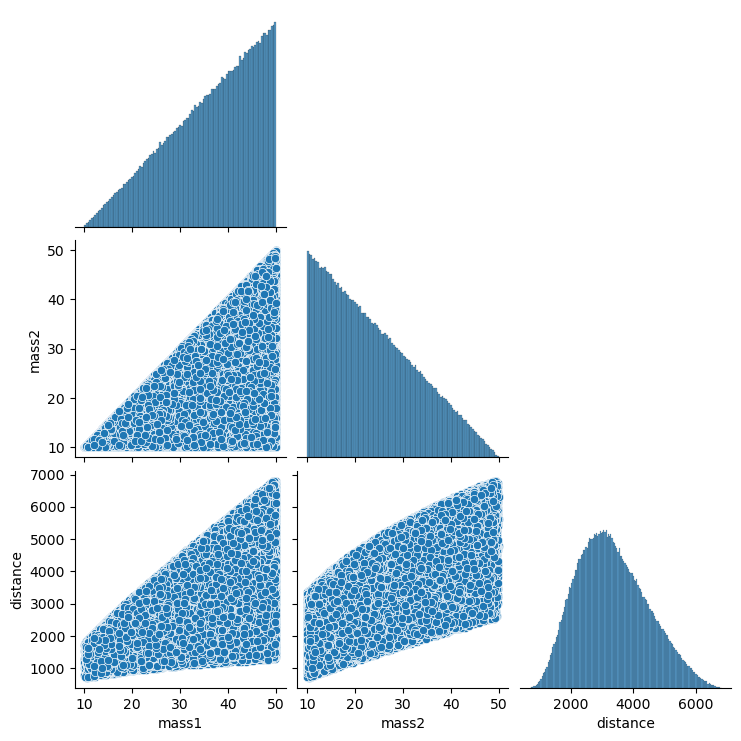

In [268]:
sns.pairplot(df, corner=True);

Nothing crazy!